In [50]:
!wget https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit1.txt

--2022-07-21 06:18:08--  https://raw.githubusercontent.com/Mehrdadghassabi/Gracc/master/BCSThesis/Source/circuits/circuit1.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71 [text/plain]
Saving to: ‘circuit1.txt.1’

circuit1.txt.1      100%[===================>]      71  --.-KB/s    in 0s      

2022-07-21 06:18:08 (3.15 MB/s) - ‘circuit1.txt.1’ saved [71/71]



In [103]:
import networkx as nx
import numpy as np
import pandas as pd
from scipy import linalg
import matplotlib.pyplot as plt

In [137]:
# this function get the example circuit information
# from .txt file by parsing it
# 
# returns kirchoff graph as the result
def circuit_parser(circ):
     nodesnumber = 0
     edgesnumber = 0
     kgedgatt = {}
     kgnodatt = {}
     i = 0
     # i is the loop variable
     with open(circ) as f:
         for line in f:
            # for each line in the .txt file get the line number i
            omitnewlines = line.replace('\n', '')
            # remove newlines
            arrstr = omitnewlines.split(" ")
            arrint = [int(numeric_string) for numeric_string in arrstr]
            # in each lines there are some numbers
            # convert the line which is a string to array of numbers
            if i == 0 :
              # if its the first line it determines 
              # number of nodes & edges
              nodesnumber = arrint[0]
              edgesnumber = arrint[1]
              kgam = np.zeros([nodesnumber,nodesnumber], dtype=int)
            else :
              # else it means that this line is an information about an edge
              # the origin and the destanation node
              # & information that an edge contains
              xmat = arrint[0]
              ymat = arrint[1]

              Coord = (xmat,ymat)
              kgam[xmat][ymat] = 1
   
              att_of_edge = {}
              att_of_edge['resistor'] = arrint[2]
              att_of_edge['battery'] = arrint[3]
              att_of_edge['capacitor'] = arrint[4]
              att_of_edge['self'] = arrint[5]
              att_of_edge['suggested_dir'] = Coord

              kgedgatt[Coord] = att_of_edge
            i = i + 1
     df = pd.DataFrame(kgam)
     kg = nx.from_pandas_adjacency(df)
     nx.set_edge_attributes(kg, kgedgatt)
     return kg

In [130]:
def plot_kirchoff_graph(kg):
    pos = nx.spring_layout(kg)
    nx.draw(kg, pos)
    plt.show()
    print('resitors: ',nx.get_edge_attributes(kg1,'resistor'))
    print('batterys: ',nx.get_edge_attributes(kg1,'battery'))
    print('capacitor: ',nx.get_edge_attributes(kg1,'capacitor'))
    print('self: ',nx.get_edge_attributes(kg1,'self'))
    print('suggested_dir: ',nx.get_edge_attributes(kg1,'suggested_dir'))

In [53]:
# this function takes kirchoff graph & minimum spaning tree
# and returns edges that eliminated 
# from kirchoff graph to build its minimum spaning tree
#
# kirchoff graph minimum spaning tree + eliminated edges = kirchoff graph 
def Eliminated_Edges(kgam,kgmstam):
    nodesnumber = len(kgam)
    l = []
    for i in range(nodesnumber):
       for j in range(nodesnumber):
           if kgam[i][j] == 1 and kgmstam[i][j]== 0 :
              if [j,i] not in l :
                 l.append([i,j])
    return np.array(l)

In [54]:
# by removing some edges from kirchoff graph
# we calculated minimum spaning tree
# for finding fundemental cycles of kirchoff graph
# we need to restore eliminated edges one by one
# and create list of graph (for more description read the doc)
# 
# this function takes minimum spaning tree (kgmst)
#  & eliminated edges as input
# and return the list that mentioned above
def graph_list(kgmstam,eled):
    i = 0
    glam = np.zeros([len(eled),len(kgmstam),len(kgmstam)], dtype=int)
    gl = []
    for edge in eled :
        glam[i] = kgmstam
        glam[i][edge[0]][edge[1]] = 1
        glam[i][edge[1]][edge[0]] = 1
        i = i + 1
    for am in glam :
        df = pd.DataFrame(am)
        g = nx.from_pandas_adjacency(df)
        gl.append(g)
    return gl
        

In [55]:
# this function get graph list as input
# and returns kirchoff graph fundamental cycles as list
def find_fundamental_cycles(gl) :
    fcl = []
    for g in gl :
        try:
           fcl.append(nx.find_cycle(g, orientation="ignore"))
        except nx.exception.NetworkXNoCycle:
           continue
    return fcl


In [56]:
def isnotreverse(org,dst,suggested_dir):
    return (suggested_dir[0] == org) and (suggested_dir[1] == dst)

In [57]:
def get_A_coord(kg,org,dst):
    edges = kg.edges()
    i = 0 
    for edge in kg.edges():
        c1 = edge[0] == org and edge[1] == dst
        c2 = edge[1] == org and edge[0] == dst
        if c1 or c2 :
           return i
        i = i + 1
    

In [101]:
def find_kg_edges_weights(kg):
    kgmst = nx.minimum_spanning_tree(kg)
    kgmstam = nx.to_numpy_array(kgmst).astype(int)
    kgam = nx.to_numpy_array(kg).astype(int)
    eled = Eliminated_Edges(kgam,kgmstam)
    gl = graph_list(kgmstam,eled)
    fcl = find_fundamental_cycles(gl)
    edge_number = kg.number_of_edges()
    B = np.zeros([edge_number,1])
    A = np.zeros([edge_number,edge_number])
    i = 0
    for cycle in fcl :
        volsum = 0
        res = 0
        for edge in cycle :
            org = edge[0]
            dst = edge[1]
            sugdir = kg.get_edge_data(org,dst)['suggested_dir']
            if isnotreverse(org,dst,sugdir) :
               volsum = volsum - kg.get_edge_data(org,dst)['battery']
               res = -kg.get_edge_data(org,dst)['resistor']
               cor = get_A_coord(kg,org,dst)
               A[i][cor] = res
            else :
               volsum = volsum + kg.get_edge_data(org,dst)['battery']
               res = +kg.get_edge_data(org,dst)['resistor']
               cor = get_A_coord(kg,org,dst)
               A[i][cor] = res
        B[i][0]= volsum
        i = i + 1
    for node in kg.nodes :
        for nei in kg1.neighbors(node):
            sugdir = kg.get_edge_data(node,nei)['suggested_dir']
            inr = isnotreverse(node,nei,sugdir)
            cor = get_A_coord(kg,node,nei)
            if isnotreverse(node,nei,sugdir) :
               A[i][cor] = -1
            else :
                 A[i][cor] = 1
        i = i + 1
        if i == kg1.number_of_edges():
           break
    return linalg.solve(A, B)

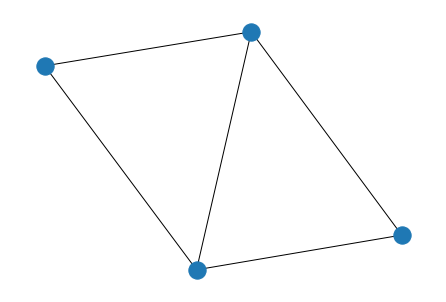

resitors:  {(0, 1): 40, (0, 2): 10, (0, 3): 20, (1, 2): 0, (1, 3): 0}
batterys:  {(0, 1): 0, (0, 2): -10, (0, 3): -20, (1, 2): 0, (1, 3): 0}
capacitor:  {(0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 2): 0, (1, 3): 0}
self:  {(0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 2): 0, (1, 3): 0}
suggested_dir:  {(0, 1): (0, 1), (0, 2): (0, 2), (0, 3): (0, 3), (1, 2): (1, 2), (1, 3): (1, 3)}


In [131]:
kg1 = circuit_parser('circuit1.txt')
plot_kirchoff_graph(kg1)